## Set up data set

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

HealthData = pd.read_csv('/Users/janruffner/Desktop/HealthcareFraudCapstoneProject/Data/HealthData.csv', index_col=0)

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
X=HealthData.drop(['PotentialFraud2','Majority', 'Majority_1', 
                  'GenderRatio', 'sum.ChronicCond_Heartfailure', 'sum.ChronicCond_stroke','sum.ChronicCond_ObstrPulmonary',
                   'sum.ChronicCond_rheumatoidarthritis', 'sum.ChronicCond_Cancer', 'sum.ChronicCond_Heartfailure', 'sum.ChronicCond_Alzheimer',
                  'sum.ChronicCond_Osteoporasis', 'sum.ChronicCond_Diabetes', 'sum.Claims', 'sum.ClaimsID', 'sum.States', 'BothServices',
                   'Inpatient', 'Outpatient', 'DistinctServices'], axis=1)
y=HealthData[['PotentialFraud2']]

## Create testing and training sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2, random_state=42)

## Initial Trial of Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
rfr = RandomForestClassifier(max_features='sqrt', random_state=42)
rfr.fit(X_train,y_train)
print(rfr.score(X_train, y_train))
print(rfr.score(X_test,y_test))

<ipython-input-5-bdc1bf11f51f>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train,y_train)


1.0
0.9417206290471786


## Grid Search for optimal hyperparameters

In [6]:
# Number of trees in random forest
n_estimators = [10,100] #[int(x) for x in np.linspace(start=10, stop=80, num=10)]
# Maximum number of levels in tree
max_depth = [i*2+4 for i in range(1,5)] + [None]
# Minimum number of samples required to split a node
min_samples_split = [1,2,4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
max_features = [8, 9, 'auto', 'sqrt'] 
# Method of selecting number of features    

bootstrap = [True]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap,
              'max_features' : max_features}

In [7]:
%timeit
rfc = RandomForestClassifier(random_state=42)
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = rfc, param_grid=param_grid, cv=5, verbose=2, n_jobs=4)
rf_Grid.fit(X_train,y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 468 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 1193 out of 1200 | elapsed:   38.3s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 1200 out of 1200 | elapsed:   38.6s finished
/Users/janruffner/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=4,
             param_grid={'bootstrap': [True], 'max_depth': [6, 8, 10, 12, None],
                         'max_features': [8, 9, 'auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [1, 2, 4],
                         'n_estimators': [10, 100]},
             verbose=2)

In [8]:
print(rf_Grid.best_params_)
rf_best = rf_Grid.best_estimator_

{'bootstrap': True, 'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


In [9]:
rf_best.fit(X_train, y_train)
print(rf_best.score(X_train, y_train))

0.9416936603424341


<ipython-input-9-24cdfa113a4a>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_best.fit(X_train, y_train)


In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, rf_best.predict(X_train))

array([[3875,   42],
       [ 210,  195]])

In [11]:
rfr = RandomForestClassifier(bootstrap=True,
                            max_depth=6, 
                            min_samples_split=2, 
                            min_samples_leaf=2, 
                            n_estimators=10, 
                            max_features=8, 
                            random_state=42) 

rfr.fit(X_train, y_train) 
print(rfr.score(X_train, y_train))

0.938917167977788


<ipython-input-11-865317b0ef07>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


In [12]:
print(rfr.score(X_test, y_test))

0.937095282146161


## Feature Importance

In [13]:
feature_importances = rfr.feature_importances_ 
feature_list = list(X_train)
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])
relative_importances.sort_values(by="importance", ascending=False)

,importance
sum.InscClaimAmtReimbursed,0.612902
OupatientInpatient2Ratio,0.090094
sum.Diagnosis,0.087246
sum.BeneID,0.082897
mean.Age,0.036415
summean_perc,0.025201
sum.AttendingPhysicians,0.025162
Majority_49,0.009298
Majority_10,0.002963
Majority_26,0.002619


<AxesSubplot:>

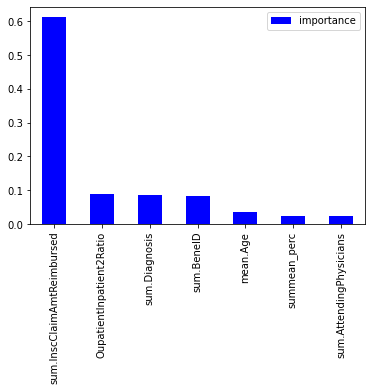

In [14]:
relative_importances.sort_values(by="importance", ascending=False).head(7).plot.bar(color='b')